# Panan01 salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41295/status,
Dashboard: /proxy/41295/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39433,Workers: 28
Dashboard: /proxy/41295/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:37337,Total threads: 1
Dashboard: /proxy/37473/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45565,


In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds[['so', 'volcello']].sel(yh=shelf_mask['yh'])
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
# Area
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello']

In [10]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

In [11]:
# Correcting area
var_C = saltC.isel(time=0,z_l=0)
var_M = saltM.isel(time=0,z_l=0)

areaC_corr = areaC*(var_C*0 +1)
areaM_corr = areaM*(var_M*0 +1)

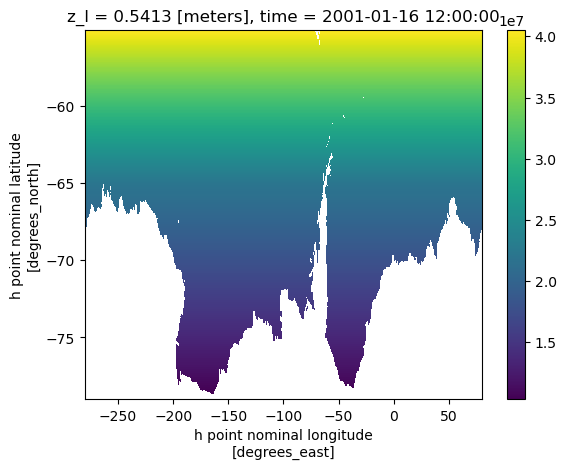

In [12]:
areaC_corr.plot()

## Bottom salinity

In [13]:
bottom_mask_saltC = saltC.where(~np.isfinite(saltC.shift({'z_l': -1})))
bottom_mask_saltC = ~np.isnan(bottom_mask_saltC)

In [14]:
bottom_mask_saltM = saltM.where(~np.isfinite(saltM.shift({'z_l': -1})))
bottom_mask_saltM = ~np.isnan(bottom_mask_saltM)

In [15]:
botsalt_cont = saltC.where(bottom_mask_saltC).sum(dim='z_l')
botsalt_pert = saltM.where(bottom_mask_saltM).sum(dim='z_l')

#### time series

In [16]:
botsalt_cont_shelf = botsalt_cont.where(shelf_mask == 1)
botsalt_pert_shelf = botsalt_pert.where(shelf_mask == 1)

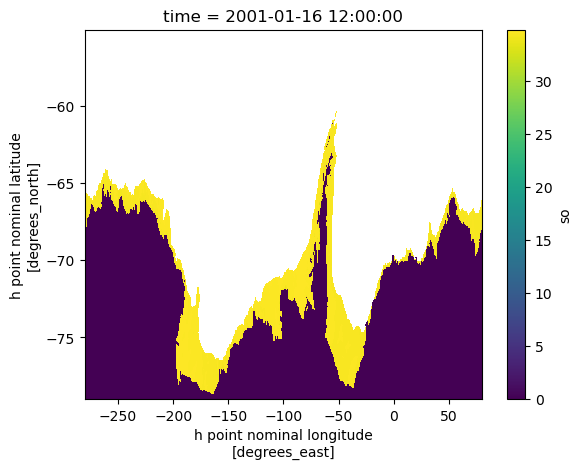

In [26]:
# Checking mask
botsalt_cont_shelf.isel(time=0).plot()

In [27]:
# Removing land
botsalt_cont_shelf = botsalt_cont_shelf*(var_C*0 +1)
botsalt_pert_shelf = botsalt_pert_shelf*(var_M*0 +1)

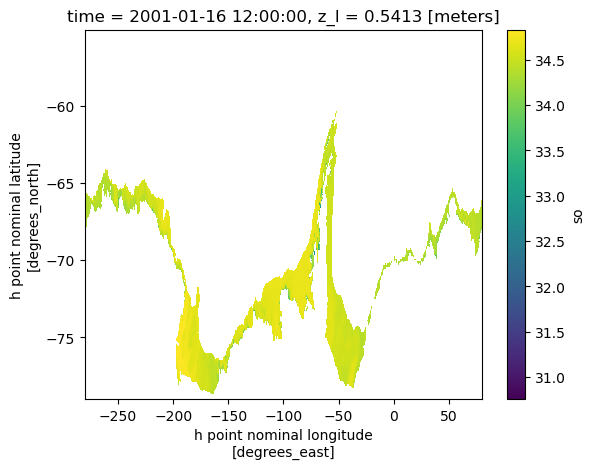

In [28]:
# Checking mask again
botsalt_cont_shelf.isel(time=0).plot()

In [32]:
# Spatial average
botsalt_cont_time = (areaC_corr * botsalt_cont_shelf).sum(['xh', 'yh']) / areaC_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
botsalt_pert_time = (areaM_corr * botsalt_pert_shelf).sum(['xh', 'yh']) / areaM_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [33]:
botsalt_cont_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [36]:
botsalt_pert_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [39]:
botsalt_cont_time = botsalt_cont_time.load()

In [40]:
botsalt_pert_time = botsalt_pert_time.load()

Text(0.5, 1.0, 'Pan01 Time Series of Bottom Salinity on Shelf')

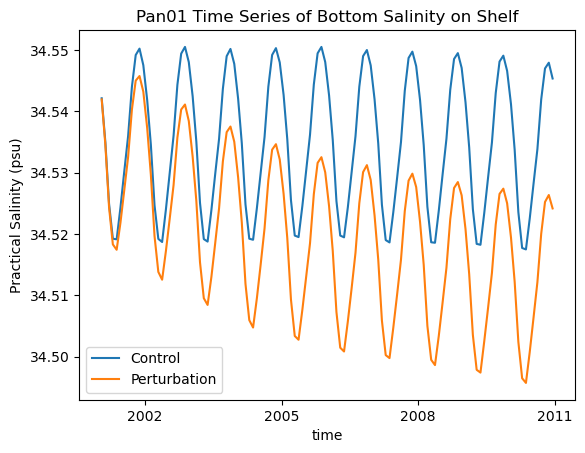

In [41]:
botsalt_cont_time.plot(label="Control")
botsalt_pert_time.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Practical Salinity (psu)")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Bottom Salinity on Shelf")

In [42]:
botsalt_anom_time = botsalt_pert_time - botsalt_cont_time
botsalt_anom_time = botsalt_anom_time.load()

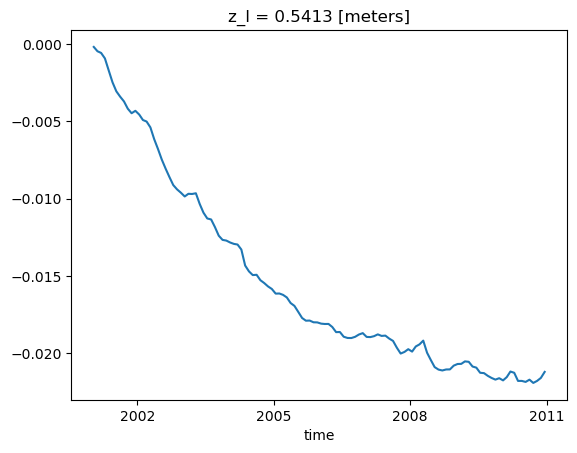

In [43]:
botsalt_anom_time.plot()

In [44]:
botsalt_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_pan01.nc')

#### Mapping bottom salinity

In [17]:
saltC_map = saltC.sel(time=slice('2006-01-01','2010-12-31'))
saltM_map = saltM.sel(time=slice('2006-01-01','2010-12-31'))

In [18]:
botsalt_cont_map = saltC_map.where(bottom_mask_saltC).sum(dim='z_l').mean(dim='time')
botsalt_pert_map = saltM_map.where(bottom_mask_saltM).sum(dim='z_l').mean(dim='time')
botsalt_anom_map = botsalt_pert_map - botsalt_cont_map

In [19]:
botsalt_anom_map = botsalt_anom_map.load()

In [20]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

In [22]:
botsalt_anom_map.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/bottom_salinity_map_Pan01.nc')

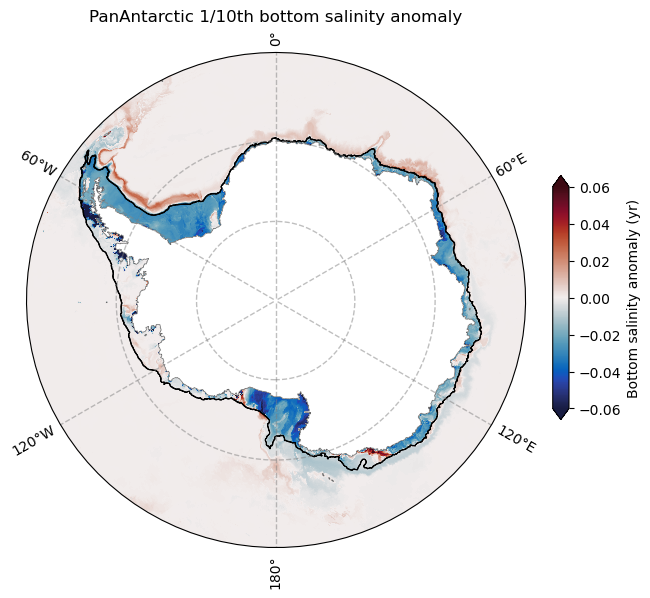

In [35]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
botsalt_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th bottom salinity anomaly");